<a href="https://colab.research.google.com/github/farghea/Pose-Detection-Biomechanics/blob/main/Lasha_Talakhadze_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yt-dlp
!apt-get install -y ffmpeg


In [ ]:
import subprocess

def download_video(url, output_filename='myVideo.mp4'):
    temp_video = "temp_video.mp4"
    temp_audio = "temp_audio.m4a"

    command_video = f'yt-dlp -f "bestvideo[ext=mp4]" -o "{temp_video}" {url}'
    command_audio = f'yt-dlp -f "bestaudio[ext=m4a]" -o "{temp_audio}" {url}'
    command_merge = f'ffmpeg -i "{temp_video}" -i "{temp_audio}" -c copy "{output_filename}"'

    process_video = subprocess.Popen(command_video, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_video, stderr_video = process_video.communicate()
    if process_video.returncode != 0:
        print("Error downloading video:")
        print(stderr_video.decode("utf-8"))
        return

    process_audio = subprocess.Popen(command_audio, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_audio, stderr_audio = process_audio.communicate()
    if process_audio.returncode != 0:
        print("Error downloading audio:")
        print(stderr_audio.decode("utf-8"))
        return

    process_merge = subprocess.Popen(command_merge, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_merge, stderr_merge = process_merge.communicate()
    if process_merge.returncode != 0:
        print("Error merging audio and video:")
        print(stderr_merge.decode("utf-8"))
    else:
        print(f"Video downloaded successfully as {output_filename}")

# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=C8RVZKtxFLo'

download_video(video_url, 'myVideo.mp4')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Video downloaded successfully as myVideo.mp4


In [ ]:
!pip install moviepy
!pip install imageio-ffmpeg


In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip

# Define start and end times in seconds
start_time = 0.8
end_time = 3.5

# Load the video
video = VideoFileClip("myVideo.mp4")

# Cut the video
clip = video.subclip(start_time, end_time)

# Save the video
clip.write_videofile("myclip.mp4")


Moviepy - Building video myclip.mp4.
MoviePy - Writing audio in myclipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video myclip.mp4



Moviepy - Done !
Moviepy - video ready myclip.mp4


In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = 'myclip.mp4'
video_file = open(video_path, 'rb')
video_bytes = video_file.read()
video_url = 'data:video/mp4;base64,' + b64encode(video_bytes).decode()
HTML(f'<video width=700 controls><source src="{video_url}" type="video/mp4"></video>')


In [ ]:
# Create frames directory
!rm -r frames
!mkdir frames


rm: cannot remove 'frames': No such file or directory


In [ ]:
import cv2
import os
import numpy as np

# Open the video file
vidcap = cv2.VideoCapture('myclip.mp4')

# Get the total frames of the video and its frames per second (fps)
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = vidcap.get(cv2.CAP_PROP_FPS)

# Generate the time variable
time_variable = np.linspace(0, total_frames/fps, total_frames)

# Read the first frame
success, image = vidcap.read()
frame_count = 0

# Loop through all frames in the video
while success:
    # Save the current frame as a JPG image
    cv2.imwrite("frames/frame%d.jpg" % frame_count, image)

    # Read the next frame
    success, image = vidcap.read()
    frame_count += 1



In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes


In [ ]:
import numpy as np

landmark_info = {
      'hip': [1, 2],
      'shoulder': [16, 17],
      'knee': [4, 5],
      'hand': [22, 23]}
def cal_mid_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  mid_point = 0.5*(pnt1 + pnt2)
  return mid_point

def get_joint_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  return np.vstack((pnt1, pnt2))


def estimate_3D_pose(jpg_file_name):
  myimg = tf.image.decode_image(tf.io.read_file(jpg_file_name))
  mypred = model.detect_poses(myimg, skeleton='smpl+head_30')

  pred_pose = mypred['poses3d'][0].numpy().reshape((30, 3))

  # lambda function to normalize a vector
  normalize = lambda vec: vec / np.linalg.norm(vec)

  # mid hip
  mid_hip = cal_mid_point('hip', pred_pose)

  # mid knee
  mid_knee = cal_mid_point('knee', pred_pose)

  # mid shoulder
  mid_shoulder = cal_mid_point('shoulder', pred_pose)

  # mid hand
  mid_hand = cal_mid_point('hand', pred_pose)

  # Shoulder length
  pnt1 = pred_pose[16, :]
  pnt2 = pred_pose[17, :]
  shoulder_length = np.linalg.norm(pnt2 - pnt1)

  # - - - Flexion angle
  v1 = mid_shoulder - mid_hip
  v1 = normalize(v1)
  v2 = np.array([0, -1, 0])
  flexion_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))
  # Check for extension
  hip_vec = get_joint_point('hip', pred_pose)
  hip_vec = normalize(hip_vec[1] - hip_vec[0])
  e_posterior = normalize(np.cross(hip_vec, v2))

  if np.dot(e_posterior, v1) > 0:
    flexion_angle = -flexion_angle

  # - - - -
  v2 = np.array([0, -1, 0])
  v1 = mid_hand - mid_shoulder
  v1 = v1/np.linalg.norm(v1)
  hand_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  # hand to mid-hip distance (normalized to the shoulder distance)
  mid_hip_to_hand_distance = np.linalg.norm(mid_hand - mid_hip)/shoulder_length

  # hand to mid-hip distance (normalized to the shoulder distance)
  projection_matrix = np.array([1, 0, 1])
  mid_shoulder_to_hand_distance = np.linalg.norm(mid_hand*projection_matrix - mid_shoulder*projection_matrix)/shoulder_length

  # Asymmetry angle
  v1 = get_joint_point('shoulder', pred_pose)
  v2 = get_joint_point('hip', pred_pose)

  v1 = v1[0, :] - v1[1, :]
  v1[1] = 0
  v1 = v1/np.linalg.norm(v1)

  v2 = v2[0, :] - v2[1, :]
  v2[1] = 0
  v2 = v2/np.linalg.norm(v2)

  asymmetry_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))
  # - - - - - - Estimate vertial hip location
  vertial_hip_location = 0.5*(mypred['poses2d'][0].numpy()[1, 1] + mypred['poses2d'][0].numpy()[2, 1])

  return flexion_angle, mid_hip_to_hand_distance, asymmetry_angle, mid_shoulder_to_hand_distance, hand_angle, vertial_hip_location



In [ ]:
analysis_results = {
    'time':   [],
    'flex_pose':   [],
    'dist_pose':    [],
    'asymmetry_angle': [],
    'shoulder_hand_dist': [],
    'hand_sagittal_angle': [],
    'vertial_hip_location': []}

counter = 0
for i in range(frame_count):
  print(i)
  myfile = f'/content/frames/frame{i}.jpg'
  pose_estimation_parameters = estimate_3D_pose(myfile)

  analysis_results['time'].append(time_variable[i])
  analysis_results['flex_pose'].append(pose_estimation_parameters[0])
  analysis_results['dist_pose'].append(pose_estimation_parameters[1])
  analysis_results['asymmetry_angle'].append(pose_estimation_parameters[2])
  analysis_results['shoulder_hand_dist'].append(pose_estimation_parameters[3])
  analysis_results['hand_sagittal_angle'].append(pose_estimation_parameters[4])
  analysis_results['vertial_hip_location'].append(pose_estimation_parameters[5])



scaling_factor = 0.3013 # Converts pixel to cm based on Talakhadzeh's height (197 cm) at standing
analysis_results['vertial_hip_location'] = np.array(analysis_results['vertial_hip_location'])
analysis_results['vertial_hip_location'] = -scaling_factor*(analysis_results['vertial_hip_location'] - analysis_results['vertial_hip_location'][0])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


  asymmetry_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))



55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


In [ ]:
# Defining a function to plot results
joint_names = model.per_skeleton_joint_names['smpl+head_30'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl+head_30'].numpy()

def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle

    plt.rcParams['font.size'] = 9
    fig = plt.figure(figsize=(18/2.54, 7/2.54))

    image_ax_no_pose = fig.add_subplot(1, 3, 1)
    image_ax_no_pose.imshow(image.numpy())

    image_ax = fig.add_subplot(1, 3, 2)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    image_ax.set_xticklabels([])
    image_ax.set_yticklabels([])

    pose_ax = fig.add_subplot(1, 3, 3, projection='3d')
    pose_ax.view_init(15, 65)
    pose_ax.set_xlim3d(-1000, 1000)
    pose_ax.set_zlim3d(-1000, 1000)
    pose_ax.set_ylim3d(1500 + 1000, 4500 + 1000)

    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)
    pose_ax.set_xticklabels([])
    pose_ax.set_yticklabels([])
    pose_ax.set_zticklabels([])

    return fig


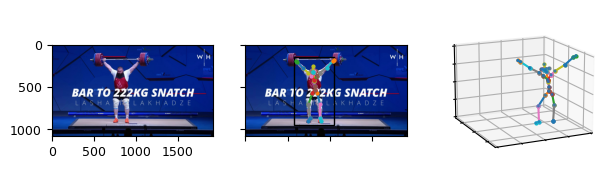

In [ ]:
# Plotting a selected frame
myfile = f'/content/frames/frame{134}.jpg'
img = tf.image.decode_image(tf.io.read_file(myfile))
mypred = model.detect_poses(img, skeleton='smpl+head_30')
myfig = plot_results(img, mypred, joint_names, joint_edges)

myfig.savefig('subplot_lasha_snatch.svg', format='svg', dpi=600)


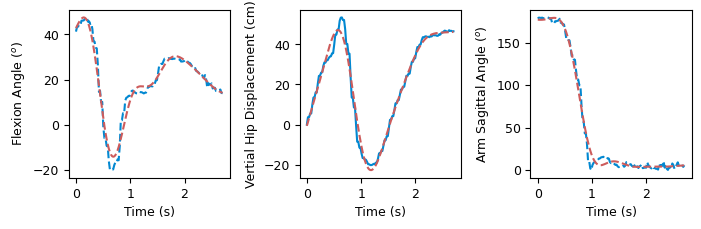

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Butterworth Low-Pass Filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Zero-Phase digital filtering
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Set the font size
plt.rcParams['font.size'] = 9

# Set the plot size
cm = 1/2.54
fig, axs = plt.subplots(1, 3, figsize=(18*cm, 6*cm))

pose_det_color = '#0288d1'
smoothed_color = 'indianred'

freq_corner = 1.5

# Flexion angle
axs[0].plot(analysis_results['time'], analysis_results['flex_pose'], '--', color = pose_det_color)
analysis_results['flex_pose_smooth'] = np.array(butter_lowpass_filter(analysis_results['flex_pose'], cutoff = freq_corner, fs = 1 / 0.02014925, order=5))
axs[0].plot(analysis_results['time'], analysis_results['flex_pose_smooth'], '--', color = smoothed_color)

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Flexion Angle ($^o$)')

# Vertial Hip Displacement
scaling_factor = 0.3013 # Converts pixel to cm based on Talakhadzeh's height (197 cm) at standing
axs[1].plot(analysis_results['time'], analysis_results['vertial_hip_location'], color = pose_det_color)
analysis_results['vertial_hip_location_smooth'] = np.array(butter_lowpass_filter(analysis_results['vertial_hip_location'], cutoff = freq_corner, fs = 1 / 0.02014925, order=5))
axs[1].plot(analysis_results['time'], analysis_results['vertial_hip_location_smooth'], '--', color = smoothed_color)

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Vertial Hip Displacement (cm)')

# Arm Sagittal Angle
axs[2].plot(analysis_results['time'], analysis_results['hand_sagittal_angle'], '--', color = pose_det_color)
analysis_results['hand_sagittal_angle_smooth'] = np.array(butter_lowpass_filter(analysis_results['hand_sagittal_angle'], cutoff = freq_corner, fs = 1 / 0.02014925, order=5))
axs[2].plot(analysis_results['time'], analysis_results['hand_sagittal_angle_smooth'], '--', color = smoothed_color)

axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Arm Sagittal Angle ($^o$)')


plt.tight_layout()
plt.savefig('subplot_lasha_plot.svg', format='svg', dpi=600)
plt.show()


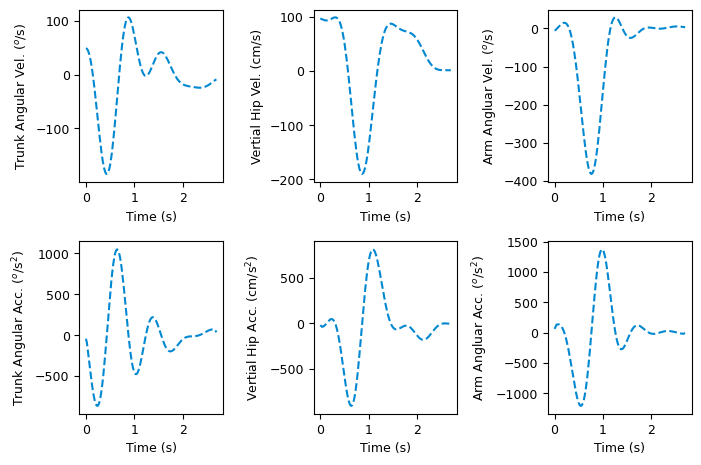

In [ ]:
# Calculate accelration and velocity
def calculate_velocity(time, data):
  velocity = np.gradient(data, time)
  return velocity

def calculate_acceleration(time, velocity):
  acceleration = np.gradient(velocity, time)
  return acceleration

variable_input = {'var': ['flex_pose_smooth', 'vertial_hip_location_smooth', 'hand_sagittal_angle_smooth'],
                  'var_label_vel': ['Trunk Angular Vel. ($^o$/s)', 'Vertial Hip Vel. (cm/s)', 'Arm Angluar Vel. ($^o$/s)'],
                  'var_label_acc': ['Trunk Angular Acc. ($^o$/s$^2$)', 'Vertial Hip Acc. (cm/s$^2$)', 'Arm Angluar Acc. ($^o$/s$^2$)'],}

# Set the plot size
cm = 1/2.54
fig, axs = plt.subplots(2, 3, figsize=(18*cm, 12*cm))

for i, input_name in enumerate(variable_input['var']):
  mydata = analysis_results[input_name]
  # Calculate velocity
  myvelocity = calculate_velocity(analysis_results['time'], mydata)
  analysis_results[input_name + '_vel'] = myvelocity

  # Caclulate acceleration
  myacceleration = calculate_acceleration(analysis_results['time'], myvelocity)
  analysis_results[input_name + '_acc'] = myacceleration

  # Plot velocity
  axs[0, i].plot(analysis_results['time'], analysis_results[input_name + '_vel'], '--', color = pose_det_color)
  axs[0, i].set_xlabel('Time (s)')
  axs[0, i].set_ylabel(variable_input['var_label_vel'][i])

  # Plot acceleration
  axs[1, i].plot(analysis_results['time'], analysis_results[input_name + '_acc'], '--', color = pose_det_color)
  axs[1, i].set_xlabel('Time (s)')
  axs[1, i].set_ylabel(variable_input['var_label_acc'][i])

plt.tight_layout()

plt.savefig('subplot_lasha_plot_1.svg', format='svg', dpi=600)


In [ ]:
# Save Results to csv
import pandas as pd

# Create the  data frame and save it
df = pd.DataFrame(analysis_results)
df.to_csv('my_results.csv', index=False)
